In [22]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cuda:0


In [23]:
a = torch.LongTensor([[1,2,3,4,5]]).to(device)
print(a[0:3].device)
print(a[:,[1,3,4]].device)
print(a.T.device)

cuda:0
cuda:0
cuda:0


# Initialize for CPU & GPU

In [24]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: file:///kaggle/input/torch-geometric


# Import

In [25]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import NNConv
from torch import autograd

from sklearn.model_selection import train_test_split

# DataLoader

In [26]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Indices = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Indices = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attrs = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_indices: Edge_Indices,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_indices: Node_Indices,
        node_attr: Node_Attr,
        timestamp_list: List,
    ):
        
        self.edge_flag = edge_flag 
        self.edge_indices = torch.LongTensor(edge_indices).T.to(device)
        self.edge_attr = edge_attr
        self.node_flag = node_flag
        self.node_indices = torch.LongTensor(node_indices).to(device)
        self.node_attr = node_attr
        self.timestamp_list = timestamp_list
        self.edge_attr_encoded = None
        self.node_attr_encoded = None
        
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.edge_flag)
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.edge_attr)).to(device)
    
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.node_attr)).to(device)
        
    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_indices[:,_start:_end]
        return _edge_index

    # def _get_edge_weight(self, time_index: int):
    #     if self.edge_weights[time_index] is None:
    #         return self.edge_weights[time_index]
    #     else:
    #         return torch.FloatTensor(self.edge_weights[time_index])

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_indices[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.timestamp_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp = _timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_indices = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_indices = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            timestamp_list = self._dataset['timestamp']
        )
        return dataset

# Model

## MultiNNConv

In [27]:
class MultiNNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_channels, gcn_hidden_nums, edge_hidden_nums, lin_hidden_nums):
        super().__init__()
        
        def _create_edge_nn(edge_out_channels):
            edge_nn = Seq()
            pre_edge_h_num = edge_channels
            for edge_h_num in edge_hidden_nums:
                edge_nn.append(Lin(pre_edge_h_num,edge_h_num))
                edge_nn.append(ReLU())
                pre_edge_h_num = edge_h_num
            edge_nn.append(Lin(pre_edge_h_num,edge_out_channels))
            return edge_nn
        
        self.gcn_layers = nn.ModuleList()
        pre_h_num = in_channels
        for h_num in gcn_hidden_nums:
            edge_nn = _create_edge_nn(pre_h_num*h_num)
            self.gcn_layers.append(NNConv(pre_h_num, h_num, edge_nn, aggr='mean'))
            pre_h_num = h_num

        self.lin_net = Seq()
        for h_num in lin_hidden_nums[:-1]:
            self.lin_net.append(Lin(pre_h_num,h_num))
            pre_h_num = h_num
        self.lin_net.append(ReLU())
        self.lin_net.append(Lin(pre_h_num,out_channels))

    def forward(self, x, edge_index, edge_attr):
        out = x
        for conv in self.gcn_layers:
            out = conv(
                x=out,
                edge_index=edge_index,
                edge_attr=edge_attr,
            )
        out = self.lin_net(out)
        return out



class NNConvGRU(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_channels: int,
        gcn_hidden_nums: List,
        edge_hidden_nums: List,
        lin_hidden_nums: List,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(NNConvGRU, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_channels = edge_channels
        self.gcn_hidden_nums = gcn_hidden_nums
        self.edge_hidden_nums = edge_hidden_nums
        self.lin_hidden_nums = lin_hidden_nums
            
        self.normalization = normalization
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiNNConv(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_hidden_nums = self.gcn_hidden_nums,
            edge_hidden_nums = self.edge_hidden_nums,
            lin_hidden_nums = self.lin_hidden_nums,
        )

        self.conv_h_z = MultiNNConv(
            in_channels = self.out_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_hidden_nums = self.gcn_hidden_nums,
            edge_hidden_nums = self.edge_hidden_nums,
            lin_hidden_nums = self.lin_hidden_nums,
        )
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiNNConv(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_hidden_nums = self.gcn_hidden_nums,
            edge_hidden_nums = self.edge_hidden_nums,
            lin_hidden_nums = self.lin_hidden_nums,
        )

        self.conv_h_r = MultiNNConv(
            in_channels = self.out_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_hidden_nums = self.gcn_hidden_nums,
            edge_hidden_nums = self.edge_hidden_nums,
            lin_hidden_nums = self.lin_hidden_nums,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiNNConv(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_hidden_nums = self.gcn_hidden_nums,
            edge_hidden_nums = self.edge_hidden_nums,
            lin_hidden_nums = self.lin_hidden_nums,
        )

        self.conv_h_h = MultiNNConv(
            in_channels = self.out_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_hidden_nums = self.gcn_hidden_nums,
            edge_hidden_nums = self.edge_hidden_nums,
            lin_hidden_nums = self.lin_hidden_nums,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_attr, H):
        Z = self.conv_x_z(X, edge_index, edge_attr)
        Z = Z + self.conv_h_z(H, edge_index, edge_attr)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_attr, H):
        R = self.conv_x_r(X, edge_index, edge_attr)
        R = R + self.conv_h_r(H, edge_index, edge_attr)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_attr, H, R):
        H_tilde = self.conv_x_h(X, edge_index, edge_attr)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_attr)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            edge_attr: torch.FloatTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
            H = self._set_hidden_state(X, H)
            Z = self._calculate_update_gate(X, edge_index, edge_attr, H)
            R = self._calculate_reset_gate(X, edge_index, edge_attr, H)
            H_tilde = self._calculate_candidate_state(X, edge_index, edge_attr, H, R)
            H = self._calculate_hidden_state(Z, H, H_tilde)
            return H

## TGAE

In [28]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, in_channels, out_channels, edge_channels, 
        embedding_hidden_nums, gnn_out_channels, deciding_hidden_nums,
        gru_gcn_hidden_nums, gru_edge_hidden_nums, gru_lin_hidden_nums):
        super(TGAE, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_channels = edge_channels
        self.embedding_hidden_nums = embedding_hidden_nums
        self.gnn_out_channels = gnn_out_channels
        self.deciding_hidden_nums = deciding_hidden_nums
        self.gru_gcn_hidden_nums = gru_gcn_hidden_nums
        self.gru_edge_hidden_nums = gru_edge_hidden_nums
        self.gru_lin_hidden_nums = gru_lin_hidden_nums
        
        # Encoder
        layers = []
        pre_h_num = in_channels
        for h_num in embedding_hidden_nums[:-1]:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embedding_hidden_nums[-1]))
        self.encoder_embedding_net = Seq(*layers)
        
        self.encoder_gru = NNConvGRU(
            in_channels=embedding_hidden_nums[-1],
            out_channels=gnn_out_channels,
            edge_channels=edge_channels,
            gcn_hidden_nums=gru_gcn_hidden_nums,
            edge_hidden_nums=gru_edge_hidden_nums,
            lin_hidden_nums=gru_lin_hidden_nums,
        )

        layers = []
        pre_h_num = gnn_out_channels
        for h_num in deciding_hidden_nums:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
        self.encoder_deciding_net = Seq(*layers)
        
        # Decoder
        layers = []
        pre_h_num = out_channels
        for h_num in deciding_hidden_nums[::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,gnn_out_channels))
        self.decoder_deciding_net = Seq(*layers)
        
        self.decoder_gru = NNConvGRU(
            in_channels=gnn_out_channels,
            out_channels=embedding_hidden_nums[-1],
            edge_channels=edge_channels,
            gcn_hidden_nums=gru_gcn_hidden_nums,
            edge_hidden_nums=gru_edge_hidden_nums,
            lin_hidden_nums=gru_lin_hidden_nums,
        )
        
        layers = []
        pre_h_num = embedding_hidden_nums[-1]
        for h_num in embedding_hidden_nums[:-1][::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,in_channels))
        self.decoder_embedding_net = Seq(*layers)
        

    def forward(self, x, edge_index, edge_attr, h_encoder=None, h_decoder=None):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        # Encoder
        out = self.encoder_embedding_net(x)
        
        # GNN layer
        h_encoder = self.encoder_gru(out, edge_index, edge_attr, h_encoder) 
        
        out = self.encoder_deciding_net(h_encoder)
        
        out = self.decoder_deciding_net(out)
        
        # TODO Reverse Edge Index 
        
        h_decoder = self.decoder_gru(out, torch.flip(edge_index,dims=(0,)), edge_attr, h_decoder)
        
        out = self.decoder_embedding_net(h_decoder)

        return out, h_encoder, h_decoder

# Training

## Global State Function

In [29]:
def create_hidden_global(num_node, out_channels):
#     hidden_global = torch.FloatTensor(np.zeros([num_node,out_channels])).to(device)
    hidden_global =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    return hidden_global

def select_hidden_local(hidden_global, index):
#     h = hidden_global[index] #REGULAR INDEXING
    h = hidden_global.index_select(dim=0, index=index) #INDEX SELECT
    return h

# TODO: Aggregation of hidden and cell
def update_hidden_gobal(hidden_global, h, index):
    # hidden_global[index] = h.detach() #REGULAR INDEXING
    # for key,value in mapping.items():
    #     hidden_global[value] = h[key] 
    hidden_global.index_copy_(dim=0, index=index, source=h)

## Read Data

In [30]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
y = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        raise

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    y.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, y_train, y_test = train_test_split(signals, y, test_size=0.2, random_state=1)
signals_train, signals_val, y_train, y_val = train_test_split(signals_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [31]:
node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.edge_attr for sample in signals_train]))

for signal in signals_train:
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)

X_train = []
for signal in signals_train:
    X_train.append(list(signal))

nums_node_train = []
for signal in signals_train:
    nums_node_train.append(signal.node_attr.shape[0])

    
for signal in signals_val:
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)

X_val = []
for signal in signals_val:
    X_val.append(list(signal))

nums_node_val = []
for signal in signals_val:
    nums_node_val.append(signal.node_attr.shape[0])

In [32]:
# for sample in X_train[:1]:
#     for snapshot in sample:
#         node_attr = snapshot.node_attr
#         node_index = snapshot.node_index
#         edge_attr = snapshot.edge_attr
#         edge_index = snapshot.edge_index
        
#         print(f"node_attr: {node_attr.shape}")
#         print(f"node_index: {node_index.shape}")
#         print(f"edge_attr: {edge_attr.shape}")
#         print(f"edge_index: {edge_index.shape}")

In [33]:
IN_CHANNELS = signals_train[0].node_attr_encoded.shape[1]
EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

In [34]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=5, 
    edge_channels=EDGE_CHANNELS, 
    embedding_hidden_nums=[16,32],
    gnn_out_channels=8,
    deciding_hidden_nums=[16,16],
    gru_gcn_hidden_nums=[16,16],
    gru_edge_hidden_nums=[32],
    gru_lin_hidden_nums=[32,16],
)

loss_f = torch.nn.MSELoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4, weight_decay=1e-5)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (encoder_embedding_net): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (encoder_gru): NNConvGRU(
    (conv_x_z): MultiNNConv(
      (gcn_layers): ModuleList(
        (0): NNConv(32, 16, aggr=mean, nn=Sequential(
          (0): Linear(in_features=58, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=512, bias=True)
        ))
        (1): NNConv(16, 16, aggr=mean, nn=Sequential(
          (0): Linear(in_features=58, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=256, bias=True)
        ))
      )
      (lin_net): Sequential(
        (0): Linear(in_features=16, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=8, bias=True)
      )
    )
    (conv_h_z): MultiNNConv(
      (gcn_layers): ModuleList(
    

In [35]:
# train_loop
def train_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_fn, optimizer, device):
    train_losses = []
    total_loss = 0
    model.train()
    for i,snapshot in enumerate(sample,start=1):
        if snapshot.node_attr.shape[0] == 0:
            # print("snapshot_{} has no data...".format(i))
            continue

        _node_index = snapshot.node_index        
        _node_attr = snapshot.node_attr
        _edge_attr = snapshot.edge_attr
        _edge_index =  snapshot.edge_index
        
        pre_h_encoder = select_hidden_local(hidden_encoder_global, _node_index)
        pre_h_decoder = select_hidden_local(hidden_decoder_global, _node_index)
        
        # print(_node_attr.type())
        # Compute prediction and loss
        outs, h_encoder, h_decoder = model(_node_attr,_edge_index,_edge_attr)

        update_hidden_gobal(hidden_encoder_global, h_encoder.detach(), _node_index)
        update_hidden_gobal(hidden_decoder_global, h_decoder.detach(), _node_index)

#         train_loss = 0
#         for i in range(_node_attr.shape[0]):
# #             train_loss += torch.sqrt(loss_f(torch.log(_node_attr[i]+1), torch.log(outs[i]+1)))
#             train_loss += torch.sqrt(torch.sum(loss_f(_node_attr[i], outs[i])))
        train_loss = torch.sum(torch.sqrt(torch.sum(loss_f(_node_attr, outs),dim=1)))
        total_loss += train_loss
        train_losses.append(train_loss.cpu().detach().numpy())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return train_losses

In [36]:
# test_loop
def test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_fn, optimizer, device):
    test_losses = []
    total_loss = 0
    with torch.no_grad():
        for i,snapshot in enumerate(sample,start=1):
            if snapshot.node_attr.shape[0] == 0:
                # print("snapshot_{} has no data...".format(i))
                continue

            _node_index = snapshot.node_index        
            _node_attr = snapshot.node_attr
            _edge_attr = snapshot.edge_attr
            _edge_index =  snapshot.edge_index

            pre_h_encoder = select_hidden_local(hidden_encoder_global, _node_index)
            pre_h_decoder = select_hidden_local(hidden_decoder_global, _node_index)

            # print(_node_attr.type())
            # Compute prediction and loss
            outs, h_encoder, h_decoder = model(_node_attr,_edge_index,_edge_attr)

            update_hidden_gobal(hidden_encoder_global, h_encoder.detach(), _node_index)
            update_hidden_gobal(hidden_decoder_global, h_decoder.detach(), _node_index)

    #         train_loss = 0
    #         for i in range(_node_attr.shape[0]):
    # #             train_loss += torch.sqrt(loss_f(torch.log(_node_attr[i]+1), torch.log(outs[i]+1)))
    #             train_loss += torch.sqrt(torch.sum(loss_f(_node_attr[i], outs[i])))
            test_loss = torch.sum(torch.sqrt(torch.sum(loss_f(_node_attr, outs),dim=1)))
            total_loss += test_loss
            test_losses.append(test_loss.cpu().detach().numpy())

    return test_losses

In [37]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    history_train = []
    history_val = []
    
    states_encoder_train = []
    states_decoder_train = []
    for num_node in nums_node_train:
        states_encoder_train.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
        states_decoder_train.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))
    
    states_encoder_val = []
    states_decoder_val = []
    for num_node in nums_node_val:
        states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
        states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for sample, y, hidden_encoder_global, hidden_decoder_global in zip(X_train, y_train, states_encoder_train, states_decoder_train):
            train_loss = train_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
    #         print(np.mean(train_loss))
            train_losses += train_loss

        # Zero Hidden State
        for state in states_encoder_train:
            state.fill_(0)
        for state in states_decoder_train:
            state.fill_(0)
        
        if i_epoch % 5 == 0:
            val_losses = []
            for sample, y, hidden_encoder_global, hidden_decoder_global in zip(X_val, y_val, states_encoder_val, states_decoder_val):
                val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
                val_losses += val_loss
            
            # Zero Hidden State
            for state in states_encoder_val:
                state.fill_(0)
            for state in states_decoder_val:
                state.fill_(0)
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train RMSE {np.mean(train_losses):.4f} val RMSE{np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train RMSE {np.mean(train_losses):.4f}")
    return (history_train,history_val)

In [38]:
history_train_list = []
history_val_list = []

In [39]:
history_train, history_val = train_function(100)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

1/100: cost 45.3919s train RMSE 83.1105
2/100: cost 44.9154s train RMSE 79.8320
3/100: cost 45.0317s train RMSE 74.3322
4/100: cost 45.3067s train RMSE 67.8973
5/100: cost 51.9429s train RMSE 60.1872 val RMSE56.4555
6/100: cost 45.7081s train RMSE 53.2672
7/100: cost 44.9127s train RMSE 44.9792
8/100: cost 45.3243s train RMSE 39.3685
9/100: cost 44.8716s train RMSE 34.2272
10/100: cost 53.1141s train RMSE 30.3822 val RMSE29.5420
11/100: cost 44.9924s train RMSE 28.9996
12/100: cost 45.0668s train RMSE 27.9563
13/100: cost 44.8418s train RMSE 27.0752
14/100: cost 44.9223s train RMSE 26.0718
15/100: cost 51.9554s train RMSE 24.5631 val RMSE23.5405
16/100: cost 45.5249s train RMSE 22.3163
17/100: cost 44.7006s train RMSE 18.5839
18/100: cost 45.1221s train RMSE 15.2929
19/100: cost 45.5413s train RMSE 13.7108
20/100: cost 51.6981s train RMSE 12.1596 val RMSE11.5615
21/100: cost 45.8037s train RMSE 11.2113
22/100: cost 44.7221s train RMSE 10.8133
23/100: cost 45.4196s train RMSE 10.4986
24

KeyboardInterrupt: 

In [ ]:
states_encoder_val = []
states_decoder_val = []
for num_node in nums_node_val:
    states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
    states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

fig = plt.figure(figsize=(20,20))    
for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
    val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
    # print(np.mean(val_loss))
    ts_list = [snapshot.timestamp for snapshot in sample]
    plt.subplot(len(X_val)+1,1,i_sample+1)
    plt.plot(ts_list,val_loss)
    if y[0] == 'dos':
        plt.axvline(x = float(y[1]), color = 'red', label = y[0])
    if y[0] == 'privesc':
        plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
plt.show()

In [ ]:
history_train, history_val = train_function(100)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

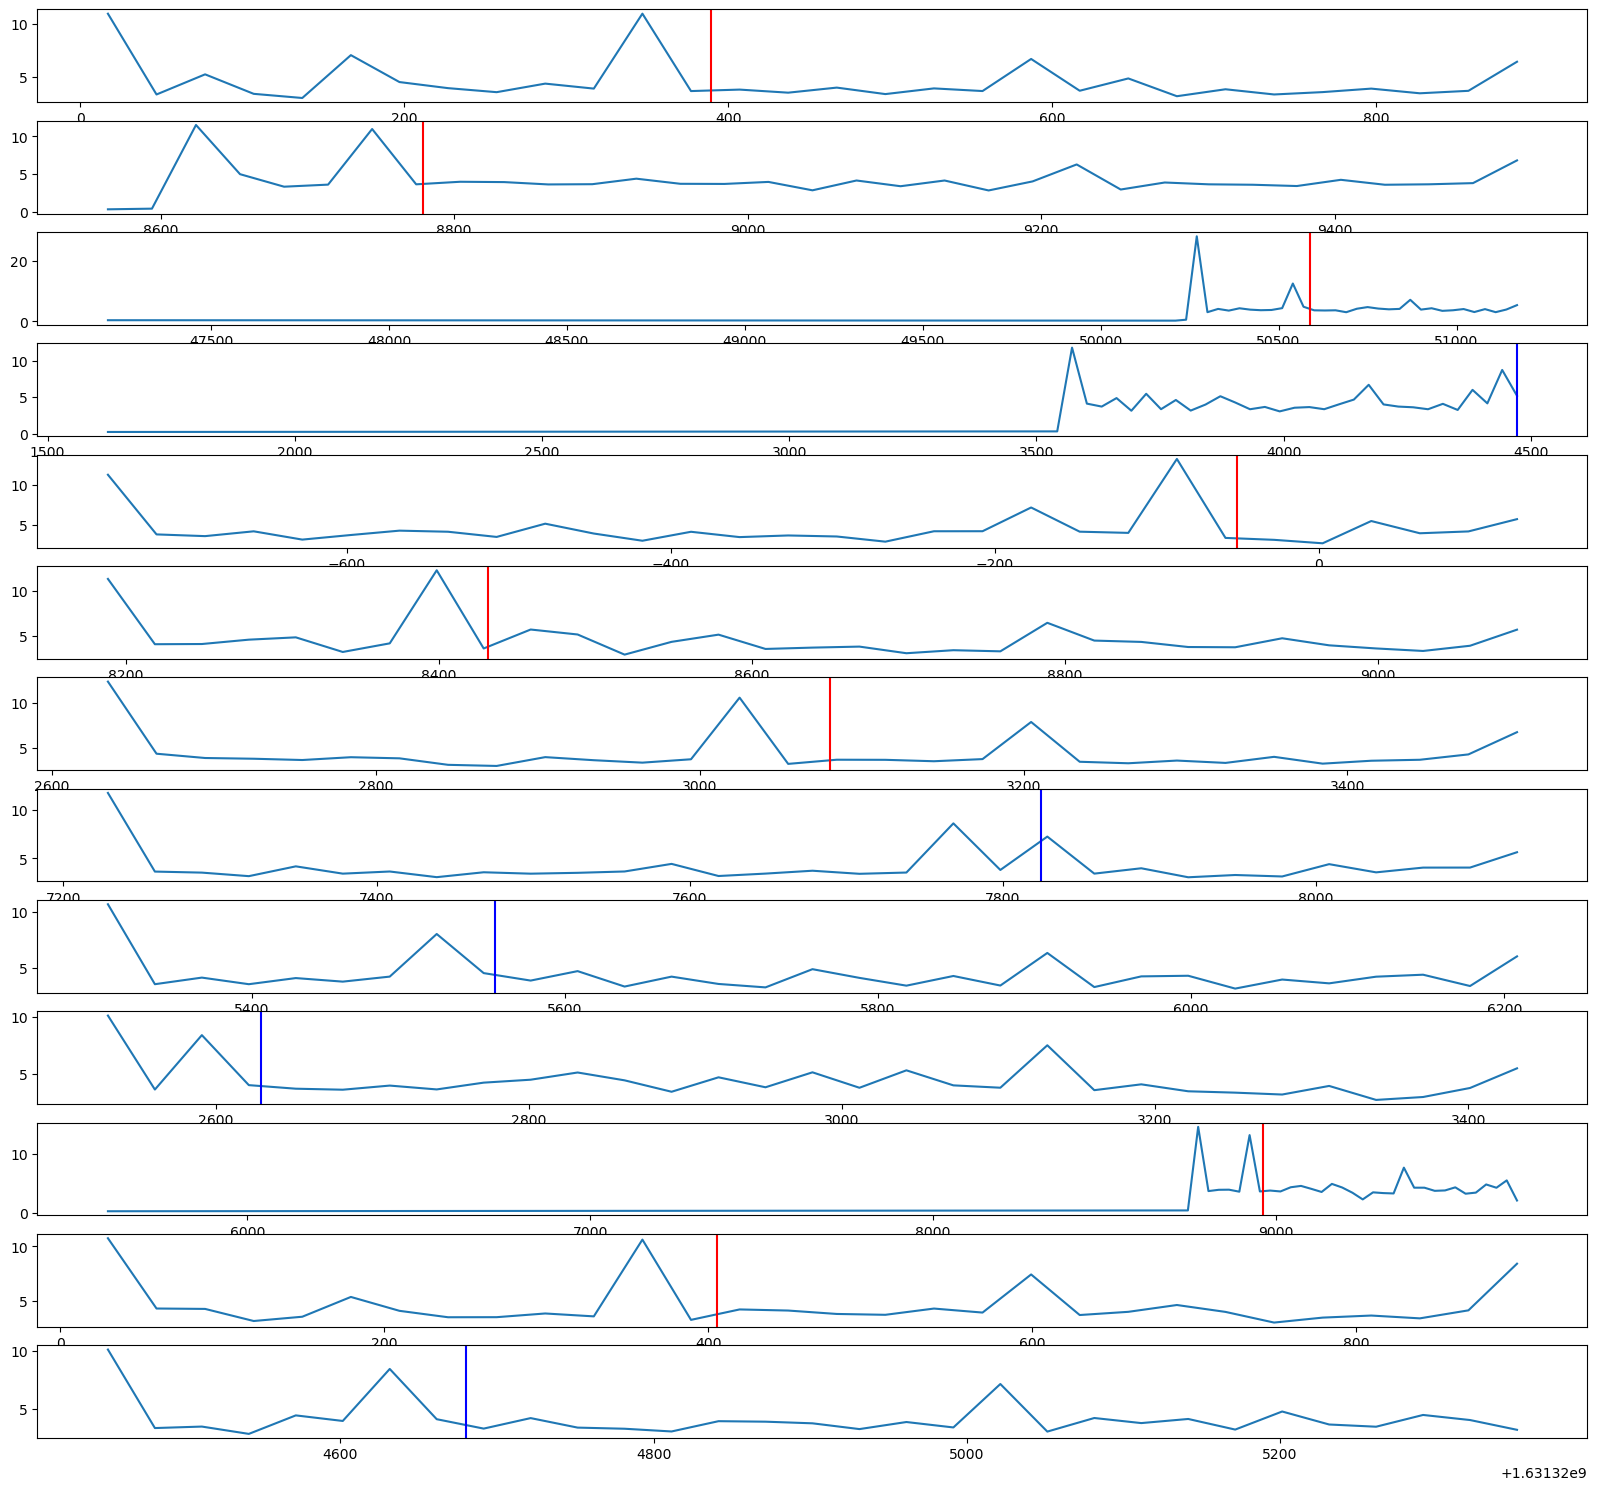

In [40]:
states_encoder_val = []
states_decoder_val = []
for num_node in nums_node_val:
    states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
    states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

fig = plt.figure(figsize=(20,20))    
for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
    val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
    # print(np.mean(val_loss))
    ts_list = [snapshot.timestamp for snapshot in sample]
    plt.subplot(len(X_val)+1,1,i_sample+1)
    plt.plot(ts_list,val_loss)
    if y[0] == 'dos':
        plt.axvline(x = float(y[1]), color = 'red', label = y[0])
    if y[0] == 'privesc':
        plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
plt.show()